In [1]:
import os
import cv2
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopandas import GeoSeries
from shapely.geometry import Polygon
from rasterio.windows import Window
from rasterio.plot import reshape_as_image


%matplotlib inline

Reading Raster with rasterio

In [2]:
PROJECT_DIR = '/home/ymi/data/ucu_data'

RASTER_PATH = os.path.join(PROJECT_DIR, 'T34JEP_20170101T082332/T34JEP_20170101T082332_TCI.jp2')
TRAIN_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/train/train.shp')
TEST_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/test/test.shp')
TRAIN_POLYGONS_CONVERTED = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/train/train.geojson')
RASTER_MASK_PATH = os.path.join(PROJECT_DIR, 'mask.jp2')
DROP_CSV_PATH = os.path.join(PROJECT_DIR, 'drop.csv')
FRAGMENT_STORAGE = os.path.join(PROJECT_DIR, 'split')
CROPPED_IMAGES = os.path.join(PROJECT_DIR, 'images_cropped_rgb')

In [3]:
# read converted dataframe with geopandas TRAIN_POLYGONS_CONVERTED
train_df = gpd.read_file(TRAIN_POLYGONS_CONVERTED)

/home/ymi/.virtualenvs/ws/lib/python3.8/site-packages/geopandas/_vectorized.py:143: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [4]:
len(train_df)

3568

In [5]:
train_df.crs

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# create tiles of each field
src = rasterio.open(RASTER_PATH, "r")
failed = 0
for num, row in train_df.iterrows():
    
    try:
        cropped_img, cropped_transform = rasterio.mask.mask(src, [train_df['geometry'].iloc[num]], crop=True, nodata=0)
        cropped_img = reshape_as_image(cropped_img)
        save_path = os.path.join(CROPPED_IMAGES, "{}.jpg".format(row['Field_Id']))
        cv2.imwrite(save_path, cropped_img)
    except Exception as error:
        failed += 1
        print(error)


Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap 

In [7]:
print(failed)

220


In [14]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

In [9]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [613924.332400085, 614051.4955277124, 614055.2810487358, 613945.3997331308, 613924.332400085]),
 array('d', [6793991.295069702, 6794016.2076526005, 6793977.493040295, 6793920.217526045, 6793991.295069702]))

In [10]:
src.shape

(10980, 10980)

In [11]:
raster_transform = src.meta.get('transform')

In [12]:
raster_transform

Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 6900040.0)

In [13]:
~raster_transform

Affine(0.1, 0.0, -49998.0,
       0.0, -0.1, 690004.0)

In [15]:
converted_poly = poly_from_utm(train_df['geometry'][0], raster_transform)

/tmp/ipykernel_31315/2017575073.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


In [20]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [613924.332400085, 614051.4955277124, 614055.2810487358, 613945.3997331308, 613924.332400085]),
 array('d', [6793991.295069702, 6794016.2076526005, 6793977.493040295, 6793920.217526045, 6793991.295069702]))

In [17]:
converted_poly.exterior.coords.xy

(array('d', [11394.433240008511, 11407.14955277124, 11407.528104873585, 11396.539973313083, 11394.433240008511]),
 array('d', [10604.87049302971, 10602.379234739929, 10606.250695970375, 10611.978247395484, 10604.87049302971]))

In [33]:

# creating binary mask for field/not_filed segmentation.

poly_shp = []

for num, row in train_df.iterrows():
    # check geom type and apply function
    # code here
    if row['geometry'].type == 'MultiPolygon':
        for poly in row['geometry']:
            converted_poly = poly_from_utm(poly, raster_transform)
            poly_shp.append(converted_poly)
    else:
        converted_poly = poly_from_utm(row['geometry'], raster_transform)
        poly_shp.append(converted_poly)
# rasterize mask mask




/tmp/ipykernel_31315/2017575073.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)
/tmp/ipykernel_31315/3627084402.py:9: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in row['geometry']:


In [38]:
# rasterize mask mask
bin_mask = rasterize(poly_shp, src.shape)

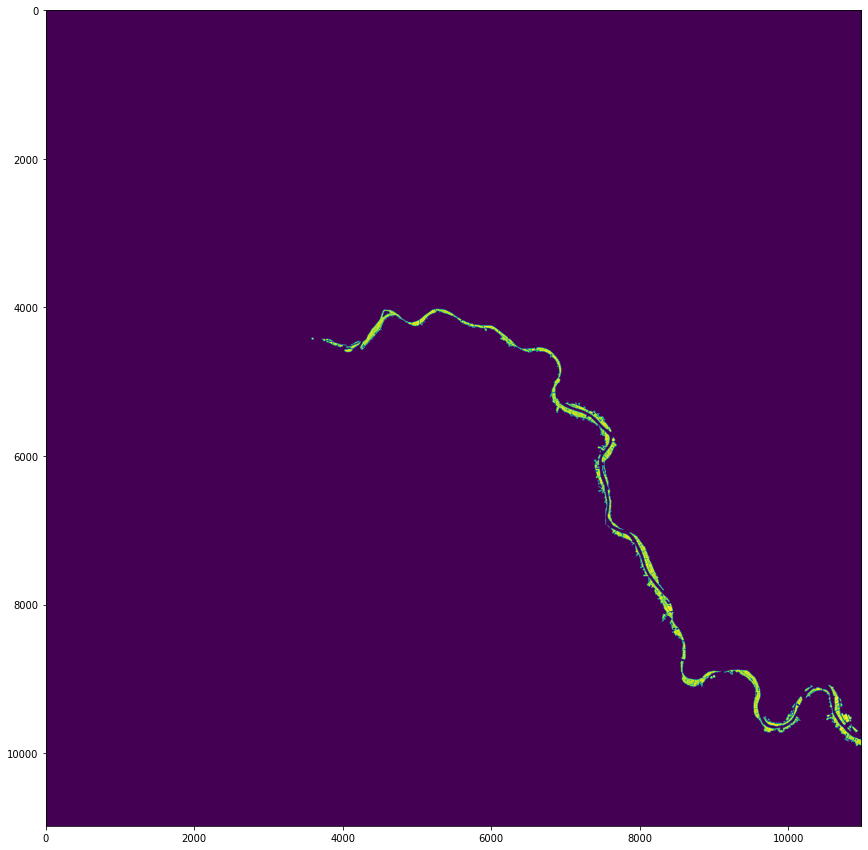

In [40]:
# plotting the mask
plt.figure(figsize=(15, 15))
plt.imshow(bin_mask)

In [41]:
meta = src.meta

In [48]:
meta.update({'count': 1})

In [56]:
meta.update({'width': 10980})

In [57]:
# save mask to the disk
with rasterio.open(RASTER_MASK_PATH, "w", **meta) as dst:
    dst.write(bin_mask, 1)

In [51]:
RASTER_MASK_PATH

'/home/ymi/data/ucu_data/mask.jp2'

In [58]:
# read from disk and plot
with rasterio.open(RASTER_MASK_PATH, "r") as src_mask:
    bin_mask = src_mask.read(1)

In [61]:
bin_mask.shape

(10980, 10980)

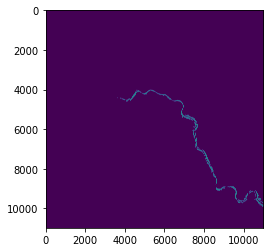

In [60]:
plt.imshow(bin_mask)

In [62]:
def split_image(image_path, save_path, width, height):
    
    img_names = []
    
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        print('Data directory created.')

    os.makedirs(f'{save_path}/images', exist_ok=True)
    with rasterio.open(image_path, "r") as src:
        for j in tqdm(range(0, src.height // height)):
            for i in range(0, src.width // width):
                raster_window = src.read(
                    window=Window(i * width, j * height, width, height)
                )
                image_array = reshape_as_image(raster_window)[:, :, :3]
                if np.count_nonzero(image_array) > image_array.size * 0.9:
                    filename_w_ext = os.path.basename(image_path)
                    filename, _ = os.path.splitext(filename_w_ext)
                    image_format = 'png'
                    piece_name = f'{filename}_{j}_{i}.{image_format}'

                    image_array = reshape_as_image(raster_window)
                    img_name = f'{save_path}/images/{piece_name}'
                    img_names.append(img_name)
                    cv2.imwrite(img_name, image_array)

    return img_names

In [85]:
#split mask
def split_mask(image_path, save_path, width, height):
    
    mask_names = []
    drop_list = []
    
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        print('Data directory created.')

    os.makedirs(f'{save_path}/masks', exist_ok=True)
    with rasterio.open(image_path) as src:
        for j in tqdm(range(0, src.height // height)):
            for i in range(0, src.width // width):
                raster_window = src.read(window=Window(i * width, j * height, width, height))
                image_array = reshape_as_image(raster_window)
                filename_w_ext = os.path.basename(image_path)
                filename, _ = os.path.splitext(filename_w_ext)
                piece_name = f'{filename}_{j}_{i}.png'

                image_array = reshape_as_image(raster_window)
                # add the code here to subsample 10% of images for train and add it to drop_list
                    
                mask_name = f'{save_path}/masks/{piece_name}'
                mask_names.append(mask_name)
                if np.sum(image_array) == 0:
                    if np.random.random() < 0.9 :
                        drop_list.append(mask_name)
                image_array[image_array>1] = 1
                cv2.imwrite(mask_name, image_array)
                

    return mask_names, drop_list

In [69]:
np.random.random()

0.543269801009091

In [64]:
image_names = split_image(RASTER_PATH, FRAGMENT_STORAGE, 256, 256)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [01:08<00:00,  1.62s/it]


In [86]:
mask_names, drop_list = split_mask(RASTER_MASK_PATH, FRAGMENT_STORAGE, 256, 256)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 12.75it/s]


In [72]:
len(drop_list)

1582

In [73]:
len(mask_names)

1764

In [87]:
drop_list_df = pd.DataFrame()
drop_list_df['images_to_drop'] = drop_list
drop_list_df.to_csv(DROP_CSV_PATH, index=False)

In [75]:
drop_list[:5]

['/home/ymi/data/ucu_data/split/masks/mask_0_0.png',
 '/home/ymi/data/ucu_data/split/masks/mask_0_1.png',
 '/home/ymi/data/ucu_data/split/masks/mask_0_2.png',
 '/home/ymi/data/ucu_data/split/masks/mask_0_3.png',
 '/home/ymi/data/ucu_data/split/masks/mask_0_4.png']

In [76]:
image_names[:5]

['/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_0.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_1.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_2.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_3.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_4.png']

In [88]:
# create by removing masks 
used_image_names = [img_name for img_name in image_names if img_name.replace("images/T34JEP_20170101T082332_TCI", "masks/mask") not in drop_list]
used_masks = [mask_names[i] for i in range(0, len(mask_names)) if mask_names[i] not in drop_list]

In [89]:
len(used_image_names)

259

In [90]:
len(used_masks)

259

In [ ]:
len(used_image_names)

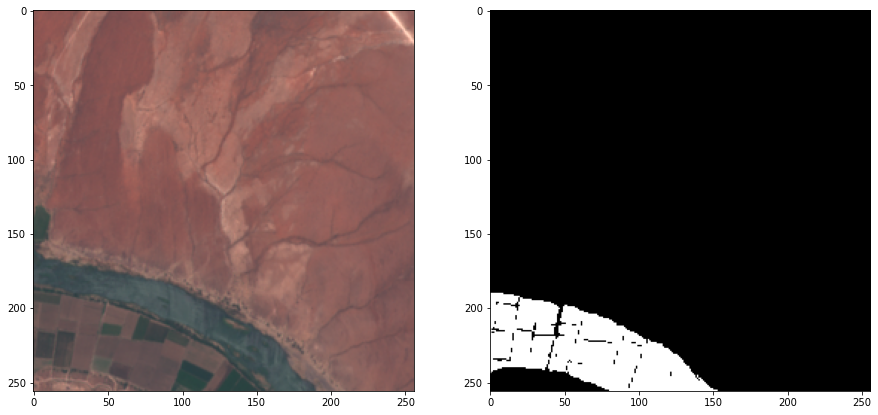

In [92]:
# read and plot tile
mask_num = 100

raster_image = cv2.imread(used_image_names[mask_num])
mask_image = cv2.imread(used_masks[mask_num], cv2.IMREAD_GRAYSCALE)


f, axarr = plt.subplots(1, 2)
f.set_size_inches(15, 15)
axarr[0].imshow(raster_image)
axarr[1].imshow(mask_image, 'gray')